# H&M Recommendation - EDA & Rule Base by Customer Age

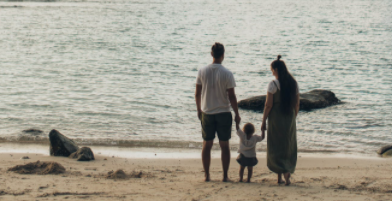

Thank you for your checking this notebook.

This is my notebook for "H&M Personalized Fashion Recommendations" competition [(Link)](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/overview) to predict purchasing articles based on rule base & customer age.

If you think this notebook is interesting, please leave your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [EDA of recent popular articles of each ages](#eda)
4. [Prediction](#pred)
5. [Submission](#sub)
6. [Conclution](#conclution)
7. [Reference](#ref)

<a id='config'></a>

---
## 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random, pickle, cudf
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from datetime import datetime, timedelta

In [ ]:
DEBUG = False
PATH_INPUT = r'../input/h-and-m-personalized-fashion-recommendations/'

<a id='load'></a>

---
## 2. Load Data
---

[Back to Contents](#top)

In [ ]:
def display_df(df, head=3):
    print(f'The shape of df is {df.shape}.\n')
    display(df.head(head))

In [ ]:
dfArticles = cudf.read_csv(PATH_INPUT + 'articles.csv', usecols=['article_id', "product_group_name", "perceived_colour_master_name"])
display_df(dfArticles, head=3)

In [ ]:
dfCustomers = cudf.read_csv(PATH_INPUT + 'customers.csv', usecols=['customer_id', 'age'])
display_df(dfCustomers, head=3)

In [ ]:
dfCustomers = dfCustomers.to_pandas()
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
dfCustomers['age_bins'] = pd.cut(dfCustomers['age'], listBin)
display_df(dfCustomers, head=3)

In [ ]:
x = dfCustomers[dfCustomers['age_bins'].isnull()].shape[0]
print(f'{x} customer_id do not have age information.\n')

In [ ]:
dfTransactions = cudf.read_csv(PATH_INPUT + 'transactions_train.csv',  
                               usecols=['t_dat', 'customer_id', 'article_id'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
dfTransactions['t_dat'] = cudf.to_datetime(dfTransactions['t_dat'])
dfTransactions.set_index('t_dat', inplace=True)
display_df(dfTransactions, head=3)

<a id='eda'></a>

---
## 3. EDA of recent popular articles of each ages

- Check the latest popular articles in each ages btw. 2020-09-01 and 2020-09-21.
- Compare that whether is there any difference btw. ages.

---

[Back to Contents](#top)

In [ ]:
dfRecent = dfTransactions.loc['2020-09-01' : '2020-09-21']
display_df(dfRecent, head=3)

In [ ]:
dfRecent = dfRecent.to_pandas()
dfRecent = dfRecent.merge(dfCustomers[['customer_id', 'age_bins']], on='customer_id', how='inner')
display_df(dfRecent, head=3)

In [ ]:
dfRecent = dfRecent.groupby(['age_bins', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})

listUniBins = dfRecent['age_bins'].unique().tolist()

dict100 = {}
for uniBin in listUniBins:
    dfTemp = dfRecent[dfRecent['age_bins'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})

In [ ]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False)

- The most smilar age is (49, 59] & (59, 69], 0.68.
- The most NOT similar age is (-1, 19] & (69, 119], 0.09.
- Based on [EDA](https://www.kaggle.com/hechtjp/eda-based-on-timeseries), (19, 29] is the most common customer's age and the most similar age for that is (29, 39], 0.59.
- At least 30% difference in top 100 articles of each ages and predictions for each ages separately would be better than one prediction for all.

<a id='pred'></a>

---
## 4. Prediction

- Predict articles for each age and save the results as csv file separately.
- Prediction is done by the rule base learned from the notebook [H&M: Faster Trending Products Weekly by Mr. HERVIND PHILIPE](https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook). (Please check and upvote it.)

---

[Back to Contents](#top)

In [ ]:
N = 12
listUniBins = dfCustomers['age_bins'].unique().tolist()

In [ ]:
for uniBin in listUniBins:
    df  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    if str(uniBin) == 'nan':
        dfCustomersTemp = dfCustomers[dfCustomers['age_bins'].isnull()]
    else:
        dfCustomersTemp = dfCustomers[dfCustomers['age_bins'] == uniBin]
    
    dfCustomersTemp = dfCustomersTemp.drop(['age_bins'], axis=1)
    dfCustomersTemp = cudf.from_pandas(dfCustomersTemp)
    
    df = df.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
    df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
    df['t_dat'] = cudf.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

    tmp = df[['t_dat']].copy().to_pandas()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    
    purchase_dict = {}

    tmp = df.copy().to_pandas()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = cudf.DataFrame(purchase_df)
    
    sub  = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub.shape[0]
    
    sub = sub.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')

    sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

    sub = sub.to_pandas()
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub.shape}. \n')
    print('-'*50)
print('Finished.\n')
print('='*50)

<a id='sub'></a>

---
## 5. Submission

- Load the saved prediction csv files and concatenate them in one dataframe.
- Save it as submission.csv.

---

[Back to Contents](#top)

In [ ]:
for i, uniBin in enumerate(listUniBins):
    dfTemp  = cudf.read_csv(f'submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = cudf.concat([dfSub, dfTemp], axis=0)

assert dfSub.shape[0] == numCustomers, f'The number of dfSub rows is not correct. {dfSub.shape[0]} vs {numCustomers}.'

dfSub.to_csv(f'submission.csv', index=False)
print(f'Saved submission.csv.')

In [ ]:
dfCheck = cudf.read_csv('./submission.csv')
display_df(dfCheck, head=3)

<a id='conclution'></a>

---

## 6. Conclution

Thank you for your reading through this Notebook!

The score on LB. is 0.0227 which is 0.0005 improved than the case which does not consider customer's age :)

If you think this notebook is interesting for you, please do click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
## 7. Reference

1.  [H&M: Faster Trending Products Weekly by Mr. HERVIND PHILIPE](https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook)

---

[Back to Contents](#top)